In [1]:
import matplotlib.pyplot as plt
import numpy as np
from botorch.models.transforms import Standardize
from gpytorch.utils.errors import NotPSDError
from hysteresis.base import TorchHysteresis
from torchAccelerator.hysteresis import HysteresisAccelerator, HysteresisQuad
from torchAccelerator.first_order import TorchDrift
import torch
from copy import deepcopy

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf


def density_function(mesh_pts):
    x = mesh_pts[:, 0]
    y = mesh_pts[:, 1]
    return torch.exp(-(y - x) / 0.5)


def beamsize(accel_model, R_i):
    return accel_model.forward(R_i)[0, 0]

def get_iterative_min(loss):
    result = torch.empty(len(loss))
    for i in range(1, len(loss)):
        result[i] = torch.min(loss[:i])
    return result

def total_beamsize(R):
    return torch.sqrt(R[0, 0] + R[2, 2])

In [2]:
def optimize(accelerator_model, initial_beam_matrix, steps = 50, apply_fields=False):

    iterations = steps
    train_X = torch.ones((1, 3)) * -0.0
    accelerator_model.q1.fantasy_H.data = train_X[0][0]
    accelerator_model.q2.fantasy_H.data = train_X[0][1]
    accelerator_model.q3.fantasy_H.data = train_X[0][2]

    train_Y = total_beamsize(
        accelerator_model.forward(initial_beam_matrix)
    ).reshape(1, 1)

    if apply_fields:
        #print(f"applying field {train_X[-1]}")
        accelerator_model.apply_fields({"q1": train_X[-1][0],
                                        "q2": train_X[-1][1],
                                        "q3": train_X[-1][2]})

    for i in range(iterations):
        std_trans = Standardize(1)
        gp = SingleTaskGP(train_X, train_Y.detach(), outcome_transform=std_trans)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        try:
            fit_gpytorch_model(mll)
        except NotPSDError:
            print('Handling NotPSDError')
            mll.load_state_dict(hypers)

        # save hyper params
        hypers = mll.state_dict()

        UCB = UpperConfidenceBound(gp, beta=2.0, maximize=False)

        bounds = torch.stack([-1.0 * torch.ones(3), torch.ones(3)])
        candidate, acq_value = optimize_acqf(
            UCB,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=20,
        )
        train_X = torch.cat((train_X, candidate))
        accelerator_model.q1.fantasy_H.data = candidate[0][0]
        accelerator_model.q2.fantasy_H.data = candidate[0][1]
        accelerator_model.q3.fantasy_H.data = candidate[0][2]

        # make next measurement
        bs = total_beamsize(
            accelerator_model.forward(initial_beam_matrix)
        ).reshape(1, 1)
        train_Y = torch.cat((train_Y, bs))

        if apply_fields:
            #print(f"applying field {train_X[-1]}")
            accelerator_model.apply_fields({"q1": train_X[-1][0],
                                            "q2": train_X[-1][1],
                                            "q3": train_X[-1][2]})

    return train_X, train_Y, accelerator_model


# hysteresis model
H = TorchHysteresis(mesh_scale=0.1, trainable=False)
dens = density_function(H.mesh_points)
H.h_min = -1.0
H.hysterion_density = dens

# define quadrupoles
d0 = TorchDrift("d0", torch.tensor(1.0))
q1 = HysteresisQuad("q1", torch.tensor(0.1), deepcopy(H), scale=torch.tensor(100.0))
d1 = TorchDrift("d1", torch.tensor(1.0))
d2 = TorchDrift("d2", torch.tensor(1.0))
q2 = HysteresisQuad("q2", torch.tensor(0.1), deepcopy(H), scale=torch.tensor(100.0))
d3 = TorchDrift("d3", torch.tensor(0.5))
q3 = HysteresisQuad("q3", torch.tensor(0.1), deepcopy(H), scale=torch.tensor(100.0))

HA = HysteresisAccelerator([d0, q1, d1, q2, d2, q3, d3])

for name, val in HA.named_parameters():
    if val.requires_grad:
        print(f"{name}:{val}")

init_beam_matrix = torch.eye(6) * 1.0e-8

#set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
init_beam_matrix[0,0] = 1.0e-3 ** 2
init_beam_matrix[1,1] = 1.0e-4 ** 2
init_beam_matrix[2,2] = 1.0e-3 ** 2
init_beam_matrix[3,3] = 1.0e-4 ** 2
R = init_beam_matrix

# plot beam size as a function of fantasy_H
h_f = torch.linspace(-1.0, 1, 100)

X = []
Y = []
all_models = []
for ele in [False, True]:
    trace_x = []
    trace_y = []
    models = []
    for _ in range(10):
        print('_')
        p, l, model = optimize(deepcopy(HA), R, apply_fields=ele, steps=100)
        trace_x += [p.clone()]
        trace_y += [torch.sqrt(l.squeeze()).detach().clone()]
        models += [deepcopy(model)]

    X += [torch.vstack([ele.unsqueeze(0) for ele in trace_x])]
    Y += [torch.vstack([ele.unsqueeze(0) for ele in trace_y])]
    all_models += [models]

X = torch.cat([ele.unsqueeze(0) for ele in X])
Y = torch.cat([ele.unsqueeze(0) for ele in Y])

q1.fantasy_H:Parameter containing:
tensor([-1.], requires_grad=True)
q2.fantasy_H:Parameter containing:
tensor([-1.], requires_grad=True)
q3.fantasy_H:Parameter containing:
tensor([-1.], requires_grad=True)
_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

Handling NotPSDError


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_
_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


_
Handling NotPSDError


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

Handling NotPSDError


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


_
Handling NotPSDError


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

_


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values det

torch.Size([2, 10, 101, 3])
torch.Size([2, 10, 101])


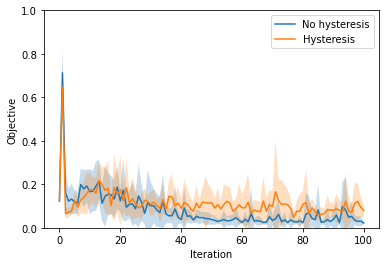

In [9]:
print(X.shape)
print(Y.shape)
fig2, ax2 = plt.subplots()

c = ['C0','C1']
labels = ['No hysteresis','Hysteresis']

for idx, ele in enumerate(Y):
    mean = torch.mean(ele, dim=0)
    std = torch.std(ele, dim=0)
    ax2.plot(mean,c[idx],label=labels[idx])
    ax2.fill_between(range(len(std)), mean-std, mean+std, fc=c[idx], alpha=0.25)
ax2.set_ylim(0,1.0)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective')
ax2.legend()
fig2.savefig('bo_hysteresis_trials.png', dpi=600)

import numpy as np
torch.save(X, 'x_opt_bayesian.pt')
torch.save(Y, 'y_opt_bayesian.pt')